In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,  StandardScaler
from matplotlib.pyplot import (figure, plot, title, xlabel, ylabel, 
                               colorbar, imshow, xticks, yticks, show)
from sklearn import model_selection, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, DistanceMetric
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary
import numpy as np

import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
import torch
import random

## Import file

In [43]:
def load():# Load the heart csv data using the Pandas library
    filename = 'heart.csv'
    df = pd.read_csv(filename)
    return df


In [54]:
def outlier_removal(df):
   # Select columns 1 to 18
   selected_columns = df.iloc[:, 0:18]
   # Calculate basic summary statistics
   summary_statistics = selected_columns.describe()

   # Drop the data set to remove outlier
   df = df.drop(df[(df.BMI > summary_statistics.BMI['mean']+2*summary_statistics.BMI['std'])
            & (df.BMI < summary_statistics.BMI['mean']-2*summary_statistics.BMI['std'])
            & (df.PhysicalHealth > summary_statistics.PhysicalHealth['mean']+2*summary_statistics.PhysicalHealth['std'])
            & (df.PhysicalHealth < summary_statistics.PhysicalHealth['mean']-2*summary_statistics.PhysicalHealth['std'])
            & (df.MentalHealth > summary_statistics.MentalHealth['mean']+2*summary_statistics.MentalHealth['std'])
            & (df.MentalHealth < summary_statistics.MentalHealth['mean']-2*summary_statistics.MentalHealth['std'])
            & (df.SleepTime > summary_statistics.SleepTime['mean']+2*summary_statistics.SleepTime['std'])
            & (df.SleepTime < summary_statistics.SleepTime['mean']-2*summary_statistics.SleepTime['std'])].index)
   
   
   return df 

In [79]:
def balanced(df):
    # Balance the data
    # Count the number of 'yes' and 'no' values in the 'label' column
    yes_count = df['HeartDisease'].value_counts()['Yes']
    no_count = df['HeartDisease'].value_counts()['No']

    # Determine the label to balance (either 'yes' or 'no')
    label_to_balance = 'Yes' if yes_count > no_count else 'No'
    label_to_keep = 'Yes' if yes_count <= no_count else 'No'

    #remove after
    columns_to_random = df[df['HeartDisease'] == label_to_keep].sample(n=100, random_state=42)
    
    # Calculate the difference in counts
    #count_diff = yes_count 
    count_diff = 100
    # Get the columns where the label is equal to label_to_balance
    columns_to_balance = df[df['HeartDisease'] == label_to_balance]

    # Randomly sample rows to make the counts equal
    sampled_rows = columns_to_balance.sample(n=count_diff, random_state=42)
    
    

    
    # Concatenate the sampled rows with the rows where the label is equal to label_to_keep
    # balance = pd.concat([df[df['HeartDisease'] == label_to_keep], sampled_rows])
    balance  = pd.concat([columns_to_random, sampled_rows])

    # Shuffle the rows to randomize the order
    balance = balance.sample(frac=1, random_state=42)

    df = balance 
    return df

In [75]:
def encode(df):
    # Transforme the discrete string into integer
    encoder = LabelEncoder()
    for col in df:
        if col != "BMI":
            df[col] = encoder.fit_transform(df[col])
    return df

In [76]:
def data_preprocess():
    df = load()
    df = outlier_removal(df)
    df = balanced(df)
    df = encode(df)
    return df

In [80]:
df = data_preprocess()
print(len(df['HeartDisease']))

200


In [81]:
# Extract the data matrix, the class label and attribute names from the csv
raw_data = df.values

Data = raw_data[:,1:]
Label = df.values [:,0]
Attributes = np.asarray(df.columns[1:].str.slice(0, 3))

In [82]:
# Summary of Dataset in percentages
print(df['HeartDisease'].value_counts(normalize=True) * 100)

1    50.0
0    50.0
Name: HeartDisease, dtype: float64


In [83]:
# Transform to mean of 0 and standard deviation of 1
Data = Data/Data.std(axis=0)
Data = Data - Data.mean(axis=0)

In [84]:
# Assign each type of class with a number by making a Python dictionary
# and extract the class vector y, convert to NumPy array
classNames = np.unique(Label)
classDict = dict(zip(classNames,range(len(classNames))))

y = np.asarray([classDict[value] for value in Label])

In [85]:
# Compute values of number of data(N), attributes(M) and classes(C).
N = len(y)
M = len(Attributes)
C = len(classNames)

# ANN

In [89]:
# Define the hyperparameters grid to search
param_grid = {
    'hidden_units': [2, 4, 8, 16, 32], # number of hidden units
    'reg_param': [0.001, 0.01, 0.1],
    'loss_fn': torch.nn.MSELoss(),
    'max_iter': 10000,
    'n_replicates': 1 # number of networks trained in each k-fold
} 
       
K_inner = 5
K_outer = 5
# Define the outer and inner cross-validation splits
outer_cv = KFold(n_splits=K_inner, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=K_outer, shuffle=True, random_state=1)

# Define a function to create a Keras model with variable hidden units and regularization
def create_model(hidden_units=4,  M=17):
    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
    return model

In [107]:
errors = []
for k, (train_index, test_index) in enumerate(inner_cv.split(Data,Label)): 
        print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K_inner))    
        
        # Extract training and test set for current CV fold, 
        # and convert them to PyTorch tensors
        X_train = torch.Tensor(Data[train_index,:] )
        y_train = torch.Tensor(Label[train_index] )
        X_test = torch.Tensor(Data[test_index,:] )
        y_test = torch.Tensor(Label[test_index] )
        
        model = create_model(param_grid['hidden_units'][k],M)
        # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
        # and see how the network is trained (search for 'def train_neural_net',
        # which is the place the function below is defined)
        net, final_loss, learning_curve = train_neural_net(model,
                                                        param_grid['loss_fn'],
                                                        X=X_train,
                                                        y=y_train,
                                                        n_replicates=param_grid['n_replicates'],
                                                        max_iter=param_grid['max_iter'])
        
        
        
        # Determine estimated class labels for test set
        y_test_est = net(X_test).squeeze()
        
        # Determine errors and errors
        se = (y_test_est.float()-y_test.float())**2 # squared error
        mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
        errors.append(mse) # store error rate for current CV fold 
        print('\n\tBest loss: {}'.format(final_loss), 'mse: {}\n'.format(mse))
    


Crossvalidation fold: 1/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.24998951	1.3709624e-06
		Final loss:
		1093	0.24996123	9.538213e-07


/Users/tinghui/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([160])) that is different to the input size (torch.Size([160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



	Best loss: 0.2499612271785736 mse: 0.25276345014572144


Crossvalidation fold: 2/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		749	0.25006428	8.342498e-07

	Best loss: 0.25006428360939026 mse: 0.2502005696296692


Crossvalidation fold: 3/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.24981335	1.3122802e-06
		Final loss:
		1069	0.24979298	8.9480983e-07

	Best loss: 0.24979297816753387 mse: 0.26846688985824585


Crossvalidation fold: 4/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		714	0.24911463	9.570629e-07

	Best loss: 0.24911463260650635 mse: 0.2646868824958801


Crossvalidation fold: 5/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		409	0.24908017	9.571952e-07

	Best loss: 0.24908016622066498 mse: 0.2621026635169983



In [ ]:
# Initialize the outer CV loop
outer_results = []
error = []
for train_index, test_index in outer_cv.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize the inner CV loop
    for k, (train_index, test_index) in enumerate(inner_cv.split(X,y)): 
        print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
        
        # Extract training and test set for current CV fold, 
        # and convert them to PyTorch tensors
        X_train = torch.Tensor(X[train_index,:] )
        y_train = torch.Tensor(y[train_index] )
        X_test = torch.Tensor(X[test_index,:] )
        y_test = torch.Tensor(y[test_index] )
        model = create_model(,M)
        # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
        # and see how the network is trained (search for 'def train_neural_net',
        # which is the place the function below is defined)
        net, final_loss, learning_curve = train_neural_net(model,
                                                        loss_fn,
                                                        X=X_train,
                                                        y=y_train,
                                                        n_replicates=3,
                                                        max_iter=max_iter)
        
        print('\n\tBest loss: {}\n'.format(final_loss))
        
        # Determine estimated class labels for test set
        y_sigmoid = net(X_test) # activation of final note, i.e. prediction of network
        y_test_est = (y_sigmoid > .5).type(dtype=torch.uint8) # threshold output of sigmoidal function
        y_test = y_test.type(dtype=torch.uint8)
        # Determine errors and error rate
        e = (y_test_est != y_test)
        error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
        errors.append(error_rate) # store error rate for current CV fold 

    inner_grid_search.fit(X_train, y_train)

    # Get the best hyperparameters from the inner CV loop
    best_params = inner_grid_search.best_params_

    # Train a model with the best hyperparameters on the entire training set
    best_model = create_model(hidden_units=best_params['hidden_units'], reg_param=best_params['reg_param'])
    best_model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0)

    # Evaluate the model on the test set
    accuracy = best_model.evaluate(X_test, y_test, verbose=0)[1]
    outer_results.append(accuracy)

# Calculate and print the final performance metric
average_accuracy = np.mean(outer_results)
print(f"Average Accuracy: {average_accuracy:.2f}")

NameError: name 'X' is not defined

# KNN

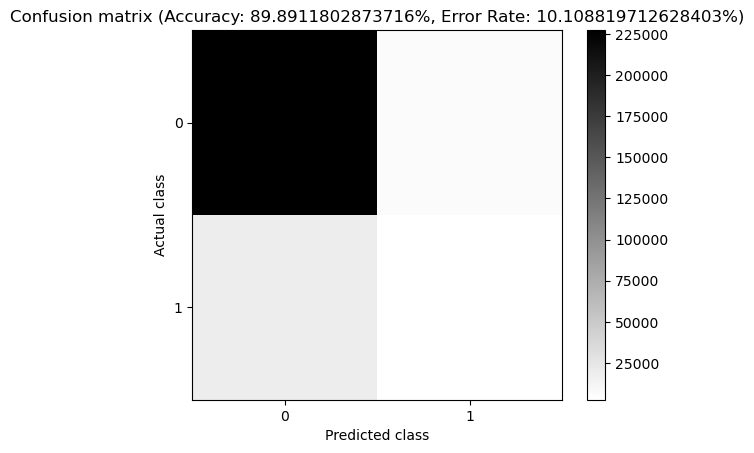

In [ ]:
K=3

# Distance metric (corresponds to 2nd norm, euclidean distance).
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist= 2
#metric = 'minkowski'
#metric_params = {} # no parameters needed for minkowski

# You can set the metric argument to 'cosine' to determine the cosine distance
metric = 'cosine' 
metric_params = {} # no parameters needed for cosine

# To use a mahalonobis distance, we need to input the covariance matrix, too:
#metric='mahalanobis'
#metric_params={'V': cov(X_train, rowvar=False)}

# Fit classifier and classify the test points
knclassifier = KNeighborsClassifier(n_neighbors=K, p=dist, 
                                    metric=metric,
                                    metric_params=metric_params)
knclassifier.fit(X_train, y_train)
y_est = knclassifier.predict(X_test)


# # Plot the classfication results
# styles = ['ob', 'or', 'og', 'oy']
# for c in range(C):
#     class_mask = (y_est==c)
#     plot(X_test[class_mask,0], X_test[class_mask,1], styles[c], markersize=10)
#     plot(X_test[class_mask,0], X_test[class_mask,1], 'kx', markersize=8)
# title('Synthetic data classification - KNN');

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_est);
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
figure(2);
imshow(cm, cmap='binary', interpolation='None');
colorbar()
xticks(range(C)); yticks(range(C));
xlabel('Predicted class'); ylabel('Actual class');
title('Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)'.format(accuracy, error_rate));

show()


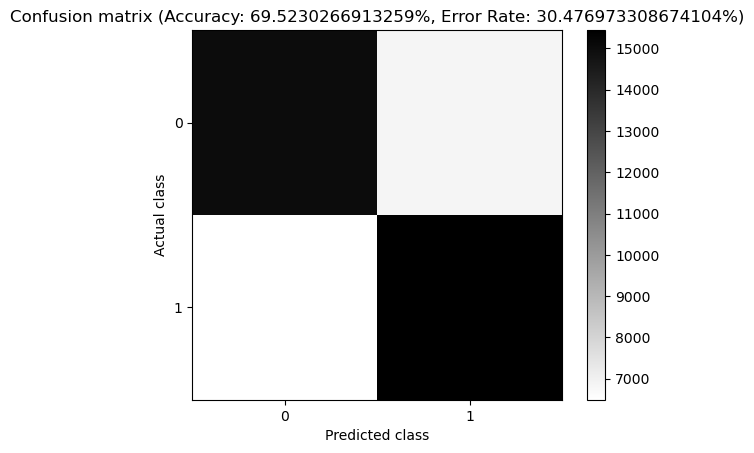

In [ ]:
K=3

# Distance metric (corresponds to 2nd norm, euclidean distance).
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist= 2
#metric = 'minkowski'
#metric_params = {} # no parameters needed for minkowski

# You can set the metric argument to 'cosine' to determine the cosine distance
metric = 'cosine' 
metric_params = {} # no parameters needed for cosine

# To use a mahalonobis distance, we need to input the covariance matrix, too:
#metric='mahalanobis'
#metric_params={'V': cov(X_train, rowvar=False)}

# Fit classifier and classify the test points
knclassifier = KNeighborsClassifier(n_neighbors=K, p=dist, 
                                    metric=metric,
                                    metric_params=metric_params)
knclassifier.fit(X_train, y_train)
y_est = knclassifier.predict(X_test)


# # Plot the classfication results
# styles = ['ob', 'or', 'og', 'oy']
# for c in range(C):
#     class_mask = (y_est==c)
#     plot(X_test[class_mask,0], X_test[class_mask,1], styles[c], markersize=10)
#     plot(X_test[class_mask,0], X_test[class_mask,1], 'kx', markersize=8)
# title('Synthetic data classification - KNN');

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_est);
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
figure(2);
imshow(cm, cmap='binary', interpolation='None');
colorbar()
xticks(range(C)); yticks(range(C));
xlabel('Predicted class'); ylabel('Actual class');
title('Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)'.format(accuracy, error_rate));

show()
